# Protein structure prediction

This notebook showcases three physics-inspired methods to predict the 3D structure of a family of proteins starting from a Multiple Sequence Alignment (MSA).
A MSA is a set of amino-acid sequences that known to be found in nature to proteins of the same family. These sequences have been modified by means operations such as deletion of one amino-acid, insertion of a gap, in order to be "as aligned as possible". More details on MSA's on [wikipedia](https://en.wikipedia.org/wiki/Multiple_sequence_alignment). 

In practice, we are given a dataset where each row is a sequence of $L$ amino-acids, each sequence corresponding to one instance of the protein family. 
The idea, going under the name of [Direct Coupling Analysis (DCA)](https://en.wikipedia.org/wiki/Direct_coupling_analysis), is to make the hypothesis that these data were sampled from an unknown probability distribution over sequences $x_1, \ldots, x_L$ which is factorized in terms of pairwise interactions
$$
p(x_1, \ldots, x_L) \propto \prod_{1\le i<j\le L} \psi_{ij}(x_i,x_j).
$$
Reconstructing the parameters in the $\psi$ factors means tracing back which pairs of sites are interacting more strongly with each other.
This is, finally, a proxy to predict which sites are in contact in the 3D structure of the protein.

_Mathematical note:_ what I find interesting about Direct Coupling Analysis is that one could think that pairwise correlation are the right object to look at in order to reconstruct the contact map. However, large correlations simply do not imply strong interactions, and vice-versa. As an example, in a Gaussian distribution the correlation matrix and the coupling matrix are inverse of one another!

In summary, this is an inverse problem where **the goal is to infer the parameters of a distribution from samples**.
As a test, we will compare the result against data about the 3D structure of the protein encoded in terms of distances between each pair of sites.

We will use here three approximate methods to solve this problem, all inspired by statistical physics techniques:
- [Gaussian DCA (GaussDCA)](https://arxiv.org/abs/1404.1240): makes the approximation of trading discrete variables (amino-acids can take 1 of 20 values) for continuous ones, for which the corresponding inference problem can be solved exactly.
- [Pseudo-likelihood maximization DCA (PlmDCA)](https://arxiv.org/abs/1401.4832): instead of maximizing the likelihood of the data given the distribution, this approach maximizes a slightly different quantity, the "pseudo-likelihood", which offers considerable computational advantages.
- [Autoregressive DCA (ArDCA)](https://arxiv.org/abs/2103.03292): this is a machine learning approach. The distribution is re-written as a product of conditional distributions, each parametrized by an autoregressive neural network $^1$. This model has the advantage that generating new samples from the learned distribution is straightforward.

$^1$ This method is not explicitly parametrizing the pairwise interactions, it's rather using a black-box approach. However there are ways to estimate interactions, as explained in the paper.

We set a few parameters:
- `family`: the protein family to be used. Available options are PF00014, PF00072, PF00076, PF00595, PF11354.
- `min_separation`: it is customary to neglect interactions between sites that are less than `min_separation` sites away along the chain, as they are considered to be trivial.
- `thresh_distance`: when dealing with the actual protein structure,two sites are considered to be bound if they are are less than `thresh_distance` (measure in Amstrong) apart.

Feel free to explore what happens with different values!

In [ ]:
family = "PF00014"

min_separation = 5

thresh_distance = 8

8

We start by loading the necessary dependencies and checking the number of available threads.
The packages we will use leverage parallel computing, so if possible consider running this notebook on multiple threads.

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\sky_9\projects\ProteinStructurePrediction`
Precompiling project...
           ✗ MKL_jll
  0 dependencies successfully precompiled in 15 seconds. 435 already precompiled.


In [2]:
Base.Threads.nthreads()

8

First, we read the Multiple Sequence Alignment file and the 3D structure file

In [11]:
using FastaIO
using DelimitedFiles

dirname = "./data/$family"
fasta_file_compressed = "$dirname/$(family)_mgap6.fasta.gz"
fasta_file = "$dirname/$(family)_mgap6.fasta"
struct_file ="$dirname/$(family)_struct.dat"
if !isdir(dirname)
    error("Directory $dirname does not exist.")
end
isfile(fasta_file_compressed) || error("Fasta file $fasta_file_compressed does not exist.")
isfile(struct_file) || error("Struct file $struct_file does not exist.")
f = readfasta(fasta_file_compressed)
nsequences = length(f)
writefasta("$(dirname)/$(family)_mgap6.fasta", f)

X = readdlm(struct_file)[:,[1,2,4]]
nsites = Int(maximum(X[:,1:2]))

score_true = [(Int(i), Int(j), v) for (i,j,v) in eachrow(X) 
                if abs(i-j) > min_separation && v < thresh_distance]
sort!(score_true, by=x->x[3])

println("MSA for protein family $family")
println("Sequence length (number of sites): $nsites")
println("Number of sequences: $nsequences")

MSA for protein family PF00595
Sequence length (number of sites): 82
Number of sequences: 36690


## Visualizing

In [7]:
using MIToS.MSA, MIToS.Pfam
###

In [ ]:
using BioMakie
using MIToS.MSA, MIToS.Pfam
using GLMakie
using Lazy
downloadpfam("pf00062")
msa1 = read_file("pf00062.stockholm.gz",Stockholm)
msa2 = Observable(msa1)
plotdata = plottingdata(msa2)
fig = Figure(size = (1400,400))
msa = plotmsa!(fig, plotdata)
coldata = lift(plotdata[:selected]) do sel
    try
        plotdata[:matrix][][:,parse(Int,sel)]
    catch
        ["-" for i in 1:size(plotdata[:matrix][])[1]]
    end
end
allaas = [  "R", "M", "N", "E", "F",
            "I", "D", "L", "A", "Q",
            "G", "C", "W", "Y", "K",
            "P", "T", "S", "V", "H",
            "X", "-"]
sortaas = sortperm(allaas)
new_aalabels = allaas[sortaas]
hydrophobicities = [BioMakie.kideradict[new_aalabels[i]][2] for i in 1:length(new_aalabels)]
countmap1 = @lift frequencies($coldata) |> sort
aas = @lift collect(keys($countmap1))
freqs = lift(aas) do a
    collect(values(countmap1[]))
end
missingaas = @lift setdiff(allaas,$aas) |> sort
missingfreqs = @lift zeros(length($missingaas))
perm1 = @lift sortperm([$aas; $missingaas])
aafreqs = @lift ([freqs[];$missingfreqs])[$perm1]
aafreqspercent = @lift $aafreqs ./ sum($aafreqs) .* 100
new_aafreqs = @lift $aafreqspercent[sortaas]
ax = Axis(fig[1,4], xticklabelsize = 16, yticks = (0:10:100), yticklabelsize = 20,
            title = "Amino Acid Percentages",
            titlesize = 18, xticks = (1:22,new_aalabels)
)
bp = barplot!(ax, 1:22, aafreqspercent; color = hydrophobicities, strokewidth = 1,
                xtickrange=1:22, xticklabels=new_aalabels
)
ylims!(ax, (0, 100))
xlims!(ax, (0, 23))

## Visualize MSA

In [ ]:
using FASTX, BioStructures
using BioMakie, CairoMakie

CairoMakie.activate!(inline=true)

reader = open(FASTX.FASTA.Reader, fasta_file)
msa = [reader...] |> Observable
close(reader)

fig_msa = plotmsa(msa; colorscheme = :tableau_blue_green)

MethodError: MethodError: no method matching GridLayout(::Tuple{Int64, Int64})
The type `GridLayout` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  GridLayout(::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any)
   @ GridLayoutBase C:\Users\sky_9\.julia\packages\GridLayoutBase\xvxWi\src\types.jl:234
  GridLayout(!Matched::Scene, Any...; kwargs...)
   @ Makie C:\Users\sky_9\.julia\packages\Makie\FUAHr\src\makielayout\helpers.jl:140
  GridLayout(!Matched::Union{GridPosition, GridSubposition}, Any...; kwargs...)
   @ GridLayoutBase C:\Users\sky_9\.julia\packages\GridLayoutBase\xvxWi\src\gridlayout.jl:14
  ...


## Contact prediction

Now we run the three methods on the input data. This can take some time depending on the size of the selected family.
I recommend starting with PF00014 which is the smallest one.

Each method outpus a vector whose elements look like `(site_i, site_j, binding_score)`, where the binding score is a measure of how strongly sites $i$ and $j$ are predicted to interact. 
The vector is sorted in descending order of score.

In [ ]:
using GaussDCA

score_gauss = gDCA(fasta_file_compressed; min_separation);

θ = 0.4157952484147446 threshold = 34.0
M = 36690 N = 82 Meff = 1566.1644366400994


3003-element Vector{Tuple{Int64, Int64, Float64}}:
 (44, 81, 1.9998151049883042)
 (58, 66, 1.3056652314983856)
 (52, 80, 1.2458575406928085)
 (28, 66, 1.2449441742432832)
 (18, 63, 1.126053919123398)
 (13, 48, 1.044044906777275)
 (37, 43, 0.8958546532107444)
 (5, 76, 0.8442422504705804)
 (33, 42, 0.8367950699801199)
 (13, 47, 0.7847379228079401)
 ⋮
 (10, 28, -0.3231456297959553)
 (19, 48, -0.32966283081060843)
 (33, 60, -0.330642854980001)
 (12, 56, -0.33255340751755347)
 (17, 66, -0.3403447127167829)
 (12, 40, -0.3497539349092361)
 (13, 18, -0.39060581012804285)
 (13, 19, -0.4023803107690128)
 (13, 34, -0.42580967383218543)

In [13]:
using PlmDCA

res = plmdca(fasta_file_compressed; verbose=true, 
    min_separation, lambdaJ=0.02, lambdaH=0.001)
score_plm = res.score;

removing duplicate sequences... done: 36690 -> 15299
θ = 0.4378425899330225 threshold = 35.0
M = 15299 N = 82 Meff = 1489.2747846436766
preprocessing took 2.0042405 seconds
site = 43	 pl = 1.0869	 time = 12.0759	site = 12	 pl = 1.0802	 time = 12.4101	exit status = FTOL_REACHED
exit status = FTOL_REACHED
site = 63	 pl = 1.8020	 time = 13.7197	exit status = FTOL_REACHED
site = 53	 pl = 0.9591	 time = 13.7236	exit status = FTOL_REACHED
site = 73	 pl = 2.0422	 time = 14.0166	exit status = FTOL_REACHED
site = 23	 pl = 1.8962	 time = 14.6564	exit status = FTOL_REACHED
site = 33	 pl = 1.1058	 time = 15.0078	exit status = FTOL_REACHED
site = 1	 pl = 0.1976	 time = 19.6554	exit status = FTOL_REACHED
site = 54	 pl = 0.7584	 time = 11.5905	exit status = FTOL_REACHED
site = 44	 pl = 0.8907	 time = 12.8353	exit status = FTOL_REACHED
site = 24	 pl = 1.3392	 time = 11.8504	exit status = FTOL_REACHED
site = 74	 pl = 2.1690	 time = 14.3032	exit status = FTOL_REACHED
site = 64	 pl = 2.2485	 time = 14.90

3003-element Vector{Tuple{Int64, Int64, Float64}}:
 (44, 81, 0.6602309578114327)
 (58, 66, 0.4552252752727619)
 (28, 66, 0.43037295702297773)
 (52, 80, 0.42456751695230316)
 (18, 63, 0.3606971734278732)
 (33, 42, 0.3075309935048275)
 (37, 43, 0.2931774247071394)
 (61, 66, 0.2698106039246203)
 (5, 76, 0.26582924205025193)
 (18, 27, 0.2528257241985689)
 ⋮
 (16, 72, -0.09726170853644361)
 (41, 66, -0.09732486282992153)
 (12, 68, -0.0992284707367691)
 (33, 60, -0.09990273304366024)
 (37, 73, -0.10353615411926334)
 (42, 58, -0.1118067700285113)
 (12, 40, -0.11539134796501804)
 (17, 66, -0.11736487022440811)
 (12, 56, -0.11764894136376364)

In [14]:
using ArDCA

arnet, arvar = ardca(fasta_file_compressed, verbose=true, lambdaJ=0.02, lambdaH=0.001)
reference_sequence_index = 1
score_ar = epistatic_score(arnet, arvar, reference_sequence_index; min_separation);

removing duplicate sequences... done: 36690 -> 15299
θ = 0.4378425899330225 threshold = 35.0
M = 15299 N = 82 Meff = 1489.2747846436766
site = 1	pl = 0.2425	time = 2.7399	status = FTOL_REACHED
site = 48	pl = 0.4461	time = 0.6861	status = FTOL_REACHED
site = 82	pl = 0.8073	time = 0.9991	status = FTOL_REACHED
site = 79	pl = 1.1611	time = 4.4313	status = FTOL_REACHED
site = 47	pl = 0.8383	time = 0.8627	status = FTOL_REACHED
site = 25	pl = 1.6915	time = 6.6586	status = FTOL_REACHED
site = 54	pl = 0.9363	time = 1.3824	status = FTOL_REACHED
site = 12	pl = 1.3778	time = 6.7492	status = FTOL_REACHED
site = 81	pl = 1.2480	time = 2.4344	status = FTOL_REACHED
site = 30	pl = 0.9462	time = 0.9951	status = FTOL_REACHED
site = 43	pl = 1.3122	time = 1.9134	status = FTOL_REACHED
site = 50	pl = 1.0337	time = 1.2322	status = FTOL_REACHED
site = 44	pl = 1.1049	time = 1.3672	status = FTOL_REACHED
site = 62	pl = 2.0663	time = 10.3001	status = FTOL_REACHED
site = 80	pl = 2.0316	time = 10.3394	status = FTOL_R

## Save intermediate files for convenience

In [15]:
using JLD2

jldsave("scores.jld2"; score_gauss, score_plm, score_ar)

In [16]:
using JLD2, UnPack

data = load("scores.jld2")
@unpack score_gauss, score_plm, score_ar = data;

## Plotting results

In order to assess the goodness of the methods, we produce two kinds of plot:
- A **contact map** which compares visually the "true" contact along the chain as extracted from the 3D information against the predicted contacts. Typically, for the prediction, one only plots the best-ranked $2L$ contacts, i.e. the ones that the model predicts with more confidence ($L$ here is the length of the protein domain measured in number of sites).
- A **ROC-like** curve where a point `(x,y)` means that among the `x` best-ranked contacts, a ration of `y` were true contacts, i.e. are also found in the 3D structure. 

In [17]:
using CairoMakie

CairoMakie.activate!(inline=true)

In [18]:
function iscontact(residue_and_score, score_true)
    i, j = residue_and_score
    return any(s -> extrema((i,j)) == extrema(s[1:2]), score_true)
end

function find_false_positives(score, score_true; ncontacts = length(score))
    @assert ncontacts ≤ length(score)
    X = zeros(Int, 0); Y = zeros(Int, 0)

    for (i,j,v) in score[1:ncontacts]
        if !iscontact((i,j,v), score_true)
            push!(X, max(i,j))
            push!(Y, min(i,j))
        end
    end
    return X, Y
end

find_false_positives (generic function with 1 method)

In [27]:
function plot_contact_map!(ax, score::Vector{Tuple{Int, Int, Float64}};
        ncontacts = lenght(score), upper=false,
        false_positives = [],
        color=:black, markersize=4, label="",
        color_fp=:red, label_fp="False positives")

    @assert ncontacts ≤ length(score)
    X = zeros(Int, ncontacts); Y = zeros(Int, ncontacts)
    for id in 1:ncontacts
        i, j, v = score[id]
        if upper
            X[id] = min(i,j); Y[id] = max(i,j)
        else
            X[id] = max(i,j); Y[id] = min(i,j)
        end
    end

    scatter!(ax, X, Y; color, markersize, label)

    if !isempty(false_positives)
        Xfp, Yfp = false_positives
        scatter!(ax, Xfp, Yfp; label=label_fp, color=color_fp, markersize)
    end

    return ax
end

plot_contact_map! (generic function with 1 method)

In [20]:
function plot_contacts_vs_true(score, score_true; 
        ncontacts=length(score), label="",
        )

    fig = Figure(size=(450, 300))
    false_positives = find_false_positives(score, score_true; ncontacts)
        
    ax = Axis(fig[1, 1]; limits=((0,nsites),(0,nsites)),
        xlabel="site", ylabel="site")

    plot_contact_map!(ax, score_true, ncontacts=length(score_true), upper=true, 
        label = "True contacts")
    plot_contact_map!(ax, score; ncontacts, color=:blue,
        label, false_positives)

    lines!(ax, min_separation:nsites, 
        (min_separation:nsites) .- min_separation, 
        color=(:gray, 0.5), linewidth=0.5)
    lines!(ax, (min_separation:nsites) .- min_separation,
        min_separation:nsites,  
        color=(:gray, 0.5), linewidth=0.5)
        
    leg = Legend(fig[1,2], ax)
    for i in eachindex(leg.entrygroups[][1][2])
        leg.entrygroups[][1][2][i].elements[1].attributes[:markersize] = Observable(6)
    end
    notify(leg.entrygroups)

    fig
end

plot_contacts_vs_true (generic function with 1 method)

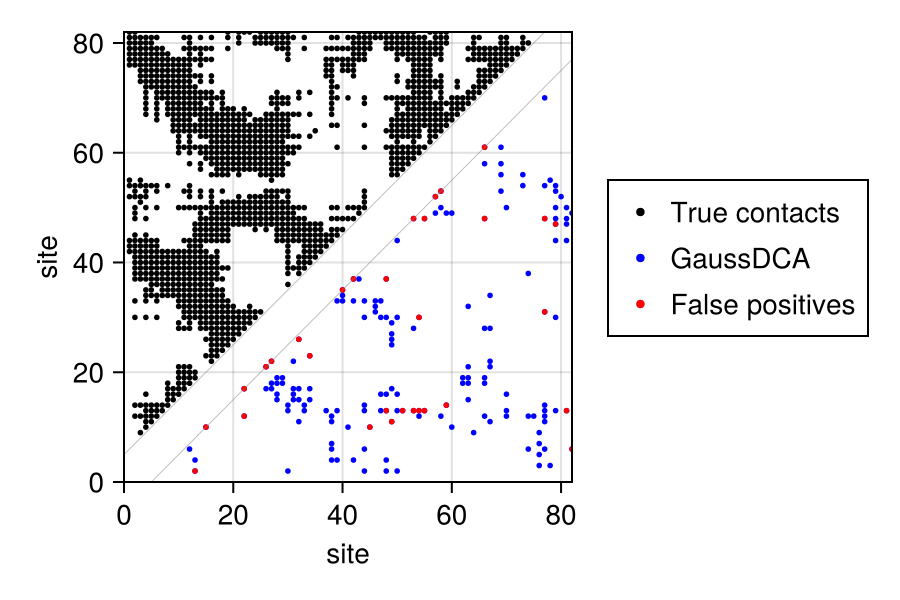

In [21]:
plot_contacts_vs_true(score_gauss, score_true; ncontacts=2nsites, label="GaussDCA")

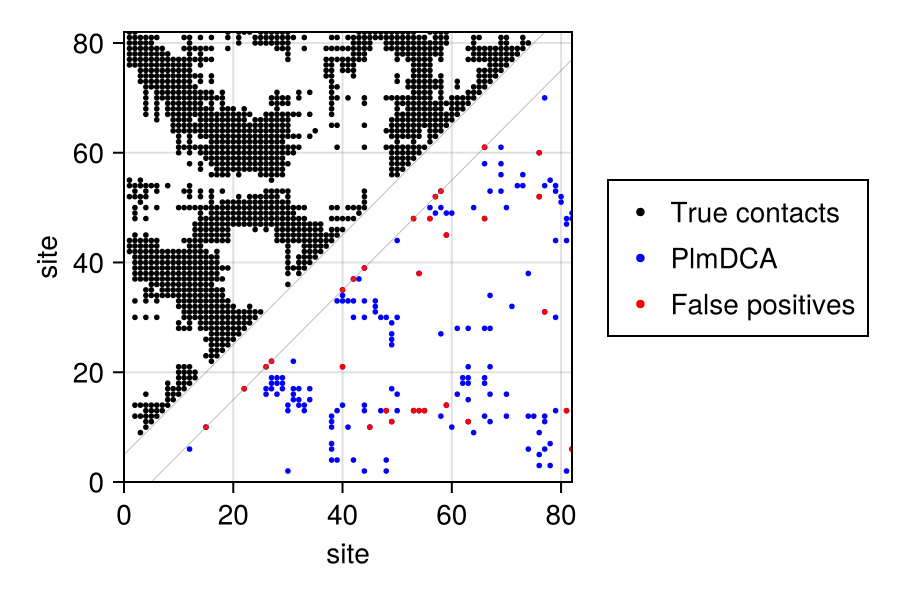

In [22]:
plot_contacts_vs_true(score_plm, score_true; ncontacts=2nsites, label="PlmDCA")

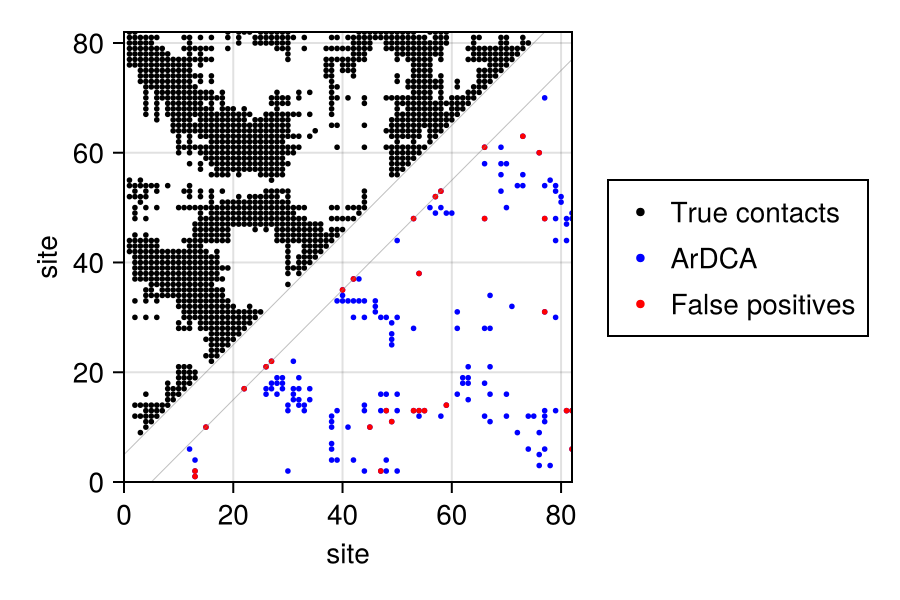

In [23]:
plot_contacts_vs_true(score_ar, score_true; ncontacts=2nsites, label="ArDCA")

In [24]:
function roc(score, score_true)
    out = zeros(length(score_true))
    n_true_positives = 0

    for n in eachindex(score_true)
        if iscontact(score[n], score_true)
            n_true_positives += 1
        end
        out[n] = n_true_positives / n
    end
    return out
end

roc (generic function with 1 method)

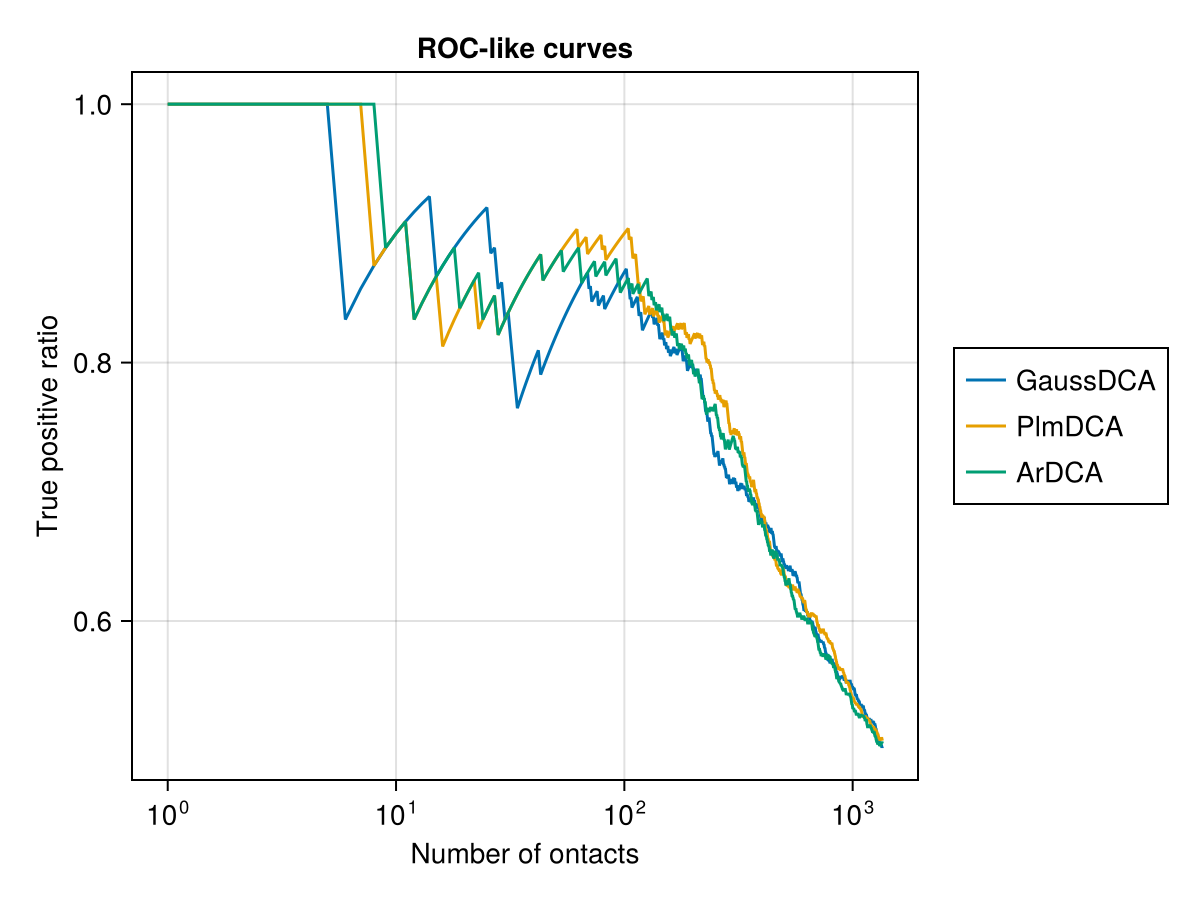

In [25]:
fig_roc = Figure(figsize=(600,400))
ax = Axis(fig_roc[1, 1];
            xlabel = "Number of ontacts", ylabel = "True positive ratio",
            xscale=log10, title="ROC-like curves")

for (score, label) in zip([score_gauss, score_plm, score_ar], ["GaussDCA", "PlmDCA", "ArDCA"])
    lines!(ax, roc(score, score_true); label)
end

fig_roc[1,2] = Legend(fig_roc, ax)

fig_roc

## Conclusions

Direct Coupling Analysis provides an effective framework to reconstruct protein structure starting from sequences and, potentially, to generate new functional proteins. 
Although these methods were to some extent made obsolete by tools such as AlphaFoldl, they surely have the advantage of interpretability.